In [1]:
# Step 1: Exploring Data
import pandas as pd
# Load the dataset
customers = pd.read_csv("Target Customer.csv")

In [2]:
# Display column names, dimensions and the first 3 rows of the dataset
customers = customers.dropna()
print(customers.columns)
print(customers.shape)
print(customers.head(3))

Index(['CustomerID', 'Gender', 'Married', 'Age', 'Graduated', 'Profession',
       'WorkExperience', 'SpendingScore', 'FamilySize', 'Category',
       'Segmentation'],
      dtype='object')
(6665, 11)
   CustomerID  Gender Married  Age Graduated  Profession  WorkExperience  \
0      462809    Male      No   22        No  Healthcare             1.0   
2      466315  Female     Yes   67       Yes    Engineer             1.0   
3      461735    Male     Yes   67       Yes      Lawyer             0.0   

  SpendingScore  FamilySize    Category Segmentation  
0           Low         4.0  Category 4            D  
2           Low         1.0  Category 6            B  
3          High         2.0  Category 6            B  


In [3]:
# Remove columns CustomerID, Category, Segmentation
customers = customers.drop(columns=['CustomerID'])
print(customers)

      Gender Married  Age Graduated  Profession  WorkExperience SpendingScore  \
0       Male      No   22        No  Healthcare             1.0           Low   
2     Female     Yes   67       Yes    Engineer             1.0           Low   
3       Male     Yes   67       Yes      Lawyer             0.0          High   
5       Male     Yes   56        No      Artist             0.0       Average   
6       Male      No   32       Yes  Healthcare             1.0           Low   
...      ...     ...  ...       ...         ...             ...           ...   
8062    Male     Yes   41       Yes      Artist             0.0          High   
8064    Male      No   35        No   Executive             3.0           Low   
8065  Female      No   33       Yes  Healthcare             1.0           Low   
8066  Female      No   27       Yes  Healthcare             1.0           Low   
8067    Male     Yes   37       Yes   Executive             0.0       Average   

      FamilySize    Categor

In [4]:
# Preprocessing the data
import numpy as np
from sklearn.preprocessing import LabelEncoder
proc_cust = customers.iloc[:, 0:8].apply(lambda x: LabelEncoder().fit_transform(x))
cust = proc_cust.values
np.round(np.mean(cust, axis=0), 2)

array([ 0.55,  0.59, 23.17,  0.64,  2.7 ,  2.63,  1.35,  1.84])

In [5]:
# Perform Principal Components Analysis (PCA)
from sklearn.decomposition import PCA
pca = PCA()
cust_pca = pca.fit_transform(proc_cust)
pca_df = pd.DataFrame(cust_pca, columns=proc_cust.columns)
summary = pd.DataFrame(index=["PC" + str(i) for i in range(1, len(pca.components_)+1)])
summary["Standard deviation"] = np.sqrt(pca.explained_variance_).round(5)
summary["Proportion of Variance"] = pca.explained_variance_ratio_.round(5)
summary["Cumulative Proportion"] = np.cumsum(pca.explained_variance_ratio_).round(5)
print(summary)

     Standard deviation  Proportion of Variance  Cumulative Proportion
PC1            15.09431                 0.91583                0.91583
PC2             3.34976                 0.04510                0.96093
PC3             2.53733                 0.02588                0.98681
PC4             1.45736                 0.00854                0.99535
PC5             0.79408                 0.00253                0.99788
PC6             0.49705                 0.00099                0.99888
PC7             0.43174                 0.00075                0.99963
PC8             0.30464                 0.00037                1.00000


In [6]:
print("Standard deviations: ")
print(np.round(np.sqrt(pca.explained_variance_), 1))
print("\nRotation (n x k) = (8 x 8):")
loading = pd.DataFrame(pca.components_.T, index=customers.columns[:8], columns=[f'PC{i}' for i in range(1, len(pca.components_)+1)])
loading *= -1
loading = loading.round(2)
print(loading)

Standard deviations: 
[15.1  3.3  2.5  1.5  0.8  0.5  0.4  0.3]

Rotation (n x k) = (8 x 8):
                 PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8
Gender         -0.00  0.01 -0.01 -0.02 -0.06  0.98  0.14  0.11
Married        -0.02 -0.00  0.03 -0.06 -0.33  0.09 -0.01 -0.94
Age            -1.00 -0.04  0.00 -0.03  0.03  0.00 -0.01  0.01
Graduated      -0.01 -0.01  0.06  0.04 -0.05 -0.14  0.99 -0.00
Profession     -0.01  0.05 -0.99  0.07 -0.11 -0.02  0.05 -0.00
WorkExperience  0.04 -1.00 -0.05 -0.07  0.01  0.01 -0.01  0.00
SpendingScore   0.02  0.00 -0.09  0.20  0.91  0.09  0.06 -0.32
FamilySize      0.03  0.07 -0.09 -0.97  0.20 -0.02  0.05 -0.02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


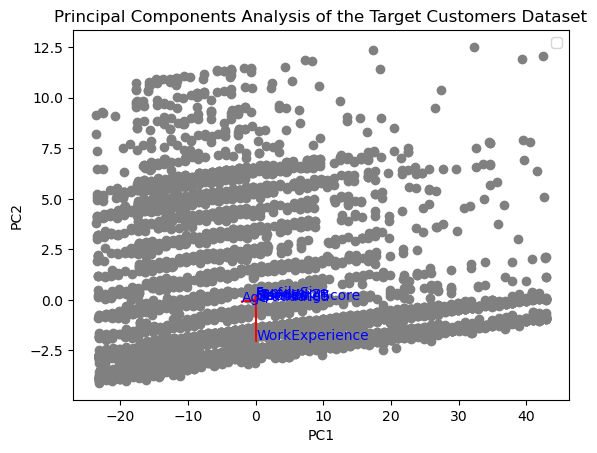

In [7]:
# Visualizing PCA loadings
import matplotlib.pyplot as plt
plt.scatter(cust_pca[:, 0], cust_pca[:, 1], color="grey")
scale = 2
for i, column_name in enumerate(customers.columns[0:8]):
    plt.arrow(0, 0, -pca.components_[0, i]*scale, -pca.components_[1, i]*scale,
              head_width=0.08, head_length=0.08, fc='red', ec='red')
    plt.text(-pca.components_[0, i] * 2, -pca.components_[1, i] * 2, column_name, color='blue')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Principal Components Analysis of the Target Customers Dataset")
plt.legend()
plt.show()

In [8]:
# Step 2: Extracting Segments
# 2.1 Using k-Means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
np.random.seed(1300)
k_values = range(3, 8)
inertia_values = []
k_result = []
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1300)
    md_k4 = kmeans.fit(pca_df)
    labels = kmeans.predict(pca_df)
    silhouette_score_ = silhouette_score(pca_df, labels)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score_)
    k_result.append(labels)

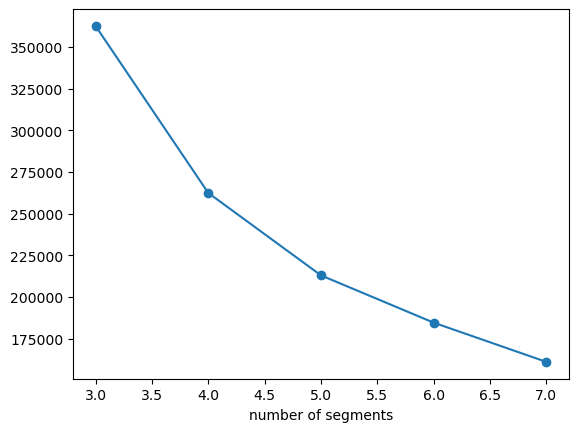

In [9]:
# Plot for the Target Customer Dataset
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel("number of segments")
plt.show()

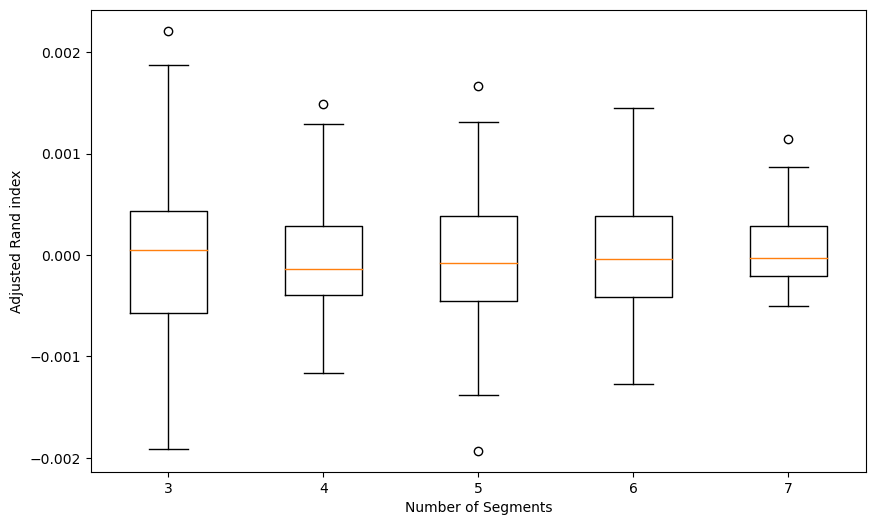

In [10]:
# Box Plot for Global stability of k-means segmentation solutions of the Target Customer Dataset.
from sklearn.metrics import adjusted_rand_score
np.random.seed(1300)
nboot = 100
ariscore = []

for labels in k_result:
    ariboot = []
    for _ in range(nboot):
        random_sample = np.random.choice(labels, size=len(labels), replace=True)
        ari = adjusted_rand_score(labels, random_sample)
        ariboot.append(ari)
    ariscore.append(ariboot)
plt.figure(figsize=(10, 6))
plt.boxplot(ariscore, labels=[str(k) for k in k_values], showfliers=True)
plt.xlabel('Number of Segments')
plt.ylabel('Adjusted Rand index')
plt.show()

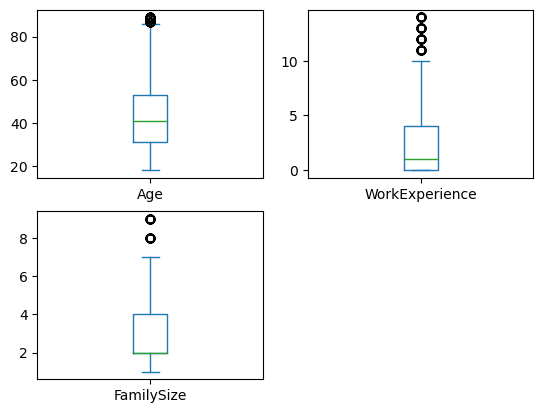

In [11]:
# Plot of each individual variable
customers.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

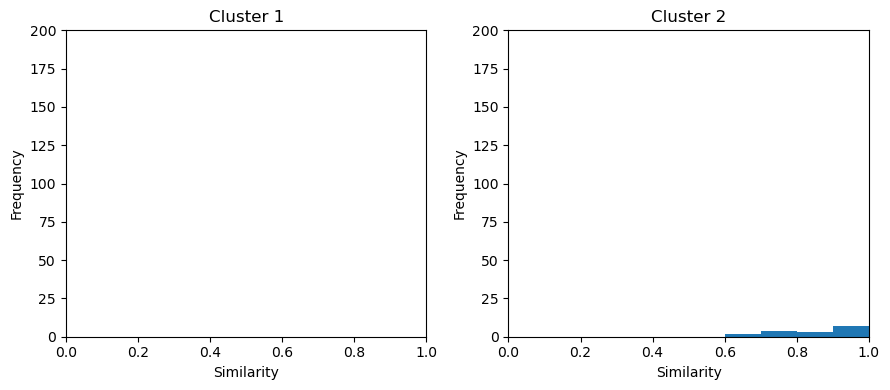

In [12]:
# Histogram of the k-means solution for the Target Customer Dataset
range_values = (0, 1)
num_bins = 10
max_frequency = 200
fig, axis = plt.subplots(1, 2, figsize=(9, 4))
for i in range(1, 3):
    cluster_i_data = proc_cust[labels == i]
    similarities = cluster_i_data.mean(axis=1)
    col = i - 1
    axis[col].hist(similarities, bins=num_bins, range=range_values)
    axis[col].set_xlabel('Similarity')
    axis[col].set_ylabel('Frequency')
    axis[col].set_title(f'Cluster {i}')
    axis[col].set_xlim(range_values)
    axis[col].set_ylim(0, max_frequency)
    axis[col].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.tight_layout()
plt.show()

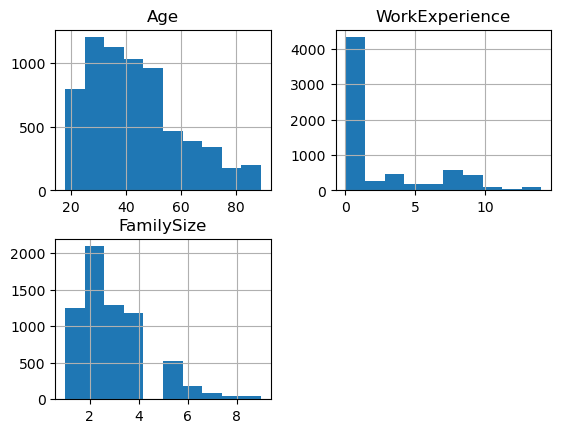

In [13]:
# Histogram
customers.hist()
plt.show()

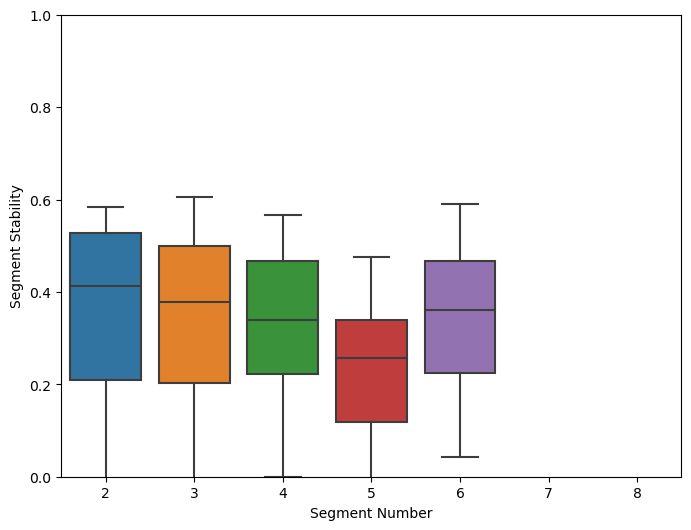

In [14]:
# Segment level stability within solutions (SLSW ) plot for the Target Customer Dataset.
import seaborn as sns
silhouette_scores = silhouette_samples(proc_cust, labels, metric='euclidean')
data = {'Segment': labels, 'Silhouette Score': silhouette_scores}
df_silhouette = pd.DataFrame(data)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Segment', y='Silhouette Score', data=df_silhouette, order=range(2, 9))
plt.xlabel('Segment Number')
plt.ylabel('Segment Stability')
plt.ylim(0, 1)
plt.show()

In [15]:
# 2.2 Using Mixtures of Distributions
# Perform Gaussian Mixture Model clustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
gausmix = GaussianMixture(n_components=4, covariance_type='full', random_state=1300)
gausmix.fit(pca_df)
clusterassignments = gausmix.predict(pca_df)
model = KMeans(n_clusters=4, n_init=10, random_state=0)
model.fit(pca_df)
labels = model.predict(pca_df)
cnmatrix = confusion_matrix(labels, clusterassignments)

print("Accuracy using Confusion Matrix:")
print(cnmatrix)

Accuracy using Confusion Matrix:
[[   0  820  815  637]
 [   2 1045  192  337]
 [  16  669   20   81]
 [   0  177 1681  173]]


In [16]:
# 2.3 Using Mixtures of Regression Models
# Reverse the frequency table
familysizecounts = customers['FamilySize'].value_counts().sort_index(ascending=False)
print(familysizecounts)

9.0      38
8.0      42
7.0      81
6.0     180
5.0     522
4.0    1174
3.0    1292
2.0    2093
1.0    1243
Name: FamilySize, dtype: int64


In [17]:
customers['FamilySize_n'] = 6 - pd.to_numeric(customers['FamilySize'], errors='coerce')
familysizecounts = customers['FamilySize_n'].value_counts().sort_index(ascending=True)
print(familysizecounts)

-3.0      38
-2.0      42
-1.0      81
 0.0     180
 1.0     522
 2.0    1174
 3.0    1292
 4.0    2093
 5.0    1243
Name: FamilySize_n, dtype: int64


In [18]:
import statsmodels.formula.api as smf
manualformula = 'FamilySize_n ~ Var1 + Var2 + Var3 + Var4 + Var5 + Var6 + Var7 + Var8'
automatedformula = 'FamilySize_n ~ ' + ' + '.join(customers.columns[0:8])
automatedformula = smf.ols(automatedformula, data=customers).fit()
print(automatedformula.model.formula)

FamilySize_n ~ Gender + Married + Age + Graduated + Profession + WorkExperience + SpendingScore + FamilySize


In [19]:
# Perform logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=1300)
logreg.fit(proc_cust, labels)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1300)

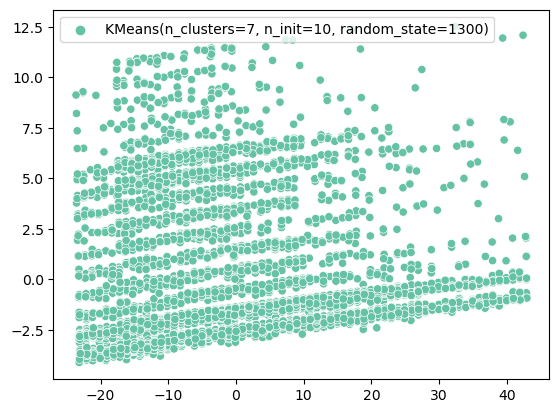

In [20]:
# Visualize the clustering results
sns.scatterplot(x=cust_pca[:, 0], y=cust_pca[:, 1], hue=md_k4, palette="Set2")
plt.show()

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


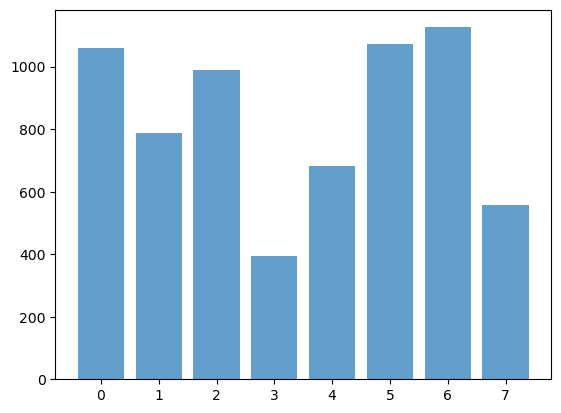

In [21]:
# Step 3: Profiling Segments
# Segment profile plot for the solution for the Target Customer Dataset
k6 = KMeans(n_clusters=8)
k6.fit(pca_df)
l6 = k6.predict(pca_df)
x = range(8)
height = []
for i in range(8):
    height.append(sum(l6 == i))
plt.bar(x, height, alpha=0.7);
plt.show()

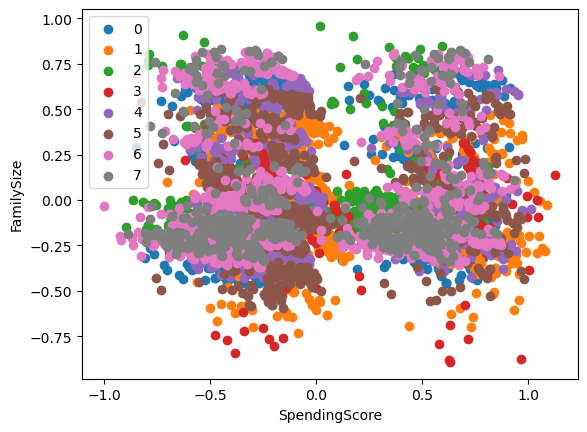

In [22]:
for i in range(8):
    temp = pca_df[['SpendingScore', 'FamilySize']][l6 == i]
    plt.scatter(temp['SpendingScore'], temp['FamilySize'], label=i)
plt.xlabel('SpendingScore')
plt.ylabel('FamilySize')
plt.legend()
plt.show()

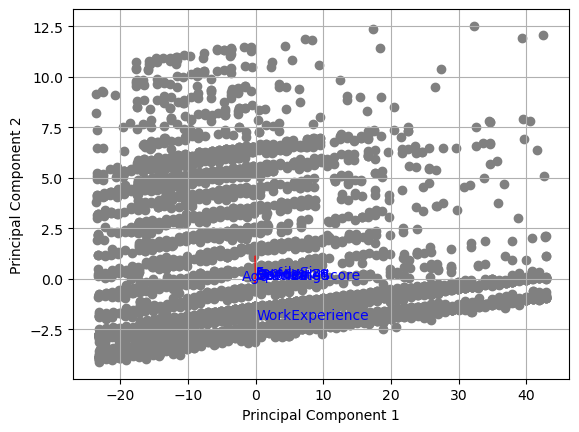

In [23]:
# Segment separation plot using principal components 1 and 2 for the Target Customer Dataset
plt.scatter(cust_pca[:, 0], cust_pca[:, 1], color='grey', label='Data Points')
for i in range(len(pca.components_)):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], color='red', alpha=0.75, linewidth=1, head_width=0.1, label=f'PC{i + 1} Axis')
for i, column_name in enumerate(customers.columns[0:8]):
    plt.text(-pca.components_[0, i] * 2, -pca.components_[1, i] * 2, column_name, color='blue')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

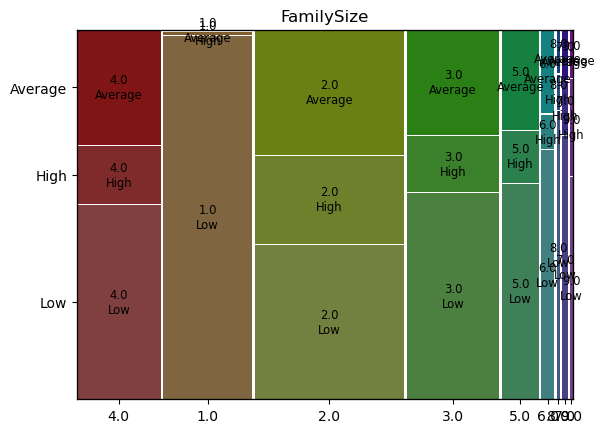

In [24]:
# Step 4: Describing Segments
# Shaded mosaic plot for cross-tabulation of segment membership and Family Size for the Target Customers Dataset
from statsmodels.graphics.mosaicplot import mosaic
data = {
    'FamilySize': customers.FamilySize,
    'SpendingScore': customers.SpendingScore
}
mosaic1 = pd.DataFrame(data)
mosaic(mosaic1,['FamilySize', 'SpendingScore'], title='FamilySize')
plt.show()

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


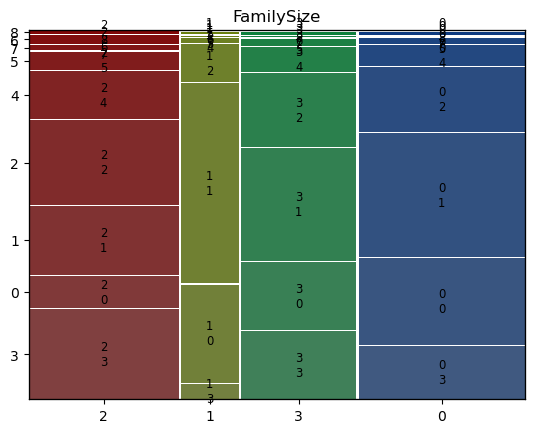

In [25]:
# Shaded mosaic plot for cross-tabulation of segment membership and Family Size for the Target Customers Dataset
kmeans = KMeans(n_clusters=4)
dataset = customers.iloc[:, :].apply(lambda x: LabelEncoder().fit_transform(x))
kmeans.fit(dataset)
dataset['cluster'] = kmeans.labels_
mosaic(data=dataset, index=['cluster', 'FamilySize'], title='FamilySize')
plt.show()

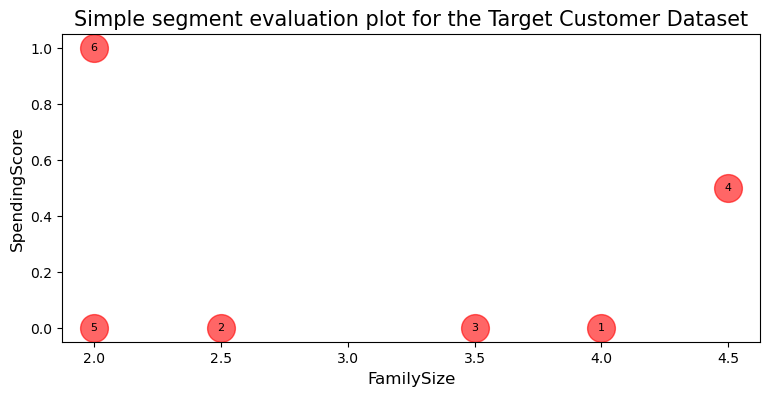

In [26]:
k4 = [1, 3, 5, 6, 4, 2, 2, 4, 5, 3]
customers = pd.DataFrame({'SpendingScore': ['Low', 'Average', 'Low', 'High', 'High', 'Average', 'Low', 'Low', 'Low', 'Average'],
                           'Gender': ['Male', 'Female', 'Female', 'Male', 'Female', 'Male', 'Male', 'Female', 'Female', 'Female'],
                           'FamilySize': [4, 3, 1, 2, 6, 2, 3, 3, 3, 4]})

FamilySize_mean = customers.groupby(k4)['FamilySize'].mean()
SpendingScore_mean = customers.groupby(k4)['SpendingScore'].apply(lambda x: (x == 'High').mean())
Gender_mean = customers.groupby(k4)['Gender'].apply(lambda x: (x == 'Male').mean())

FamilySize_values = FamilySize_mean.values
SpendingScore_values = SpendingScore_mean.values
Gender_values = Gender_mean.values

plt.figure(figsize=(9, 4))
plt.scatter(FamilySize_values, SpendingScore_values, s=400, c='red', alpha=0.6)  # 's' is marker size
plt.title("Simple segment evaluation plot for the Target Customer Dataset", fontsize=15)
plt.xlabel("FamilySize", fontsize=12)
plt.ylabel("SpendingScore", fontsize=12)

for i, txt in enumerate(range(1, len(FamilySize_values) + 1)):
    plt.text(FamilySize_values[i], SpendingScore_values[i], str(txt), fontsize=8, ha='center', va='center')

plt.show()